In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
import seaborn as sns
import shapely as sh
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [2]:
comm_areas_df = pd.read_csv('./datasets/CommAreas_20241114.csv')
my_chi_df = pd.read_csv('./datasets/My_CHI._My_Future._Programs_20241113.csv')
income_df = pd.read_csv('./datasets/Census_Data.csv')


### Distribution of variables
*By Sylvia Sherwood*

In [3]:
#...Plot for distribution of variables...#



### Data cleaning
*By Sankaranarayanan Balasubramanian & Fiona Fe*

In [4]:
# Convert CommAreas to a GeoDataFrame, from geographic boundaries stored in 'the_geom' to use for geospatial operations
comm_areas_gdf = gpd.GeoDataFrame(comm_areas_df, geometry=gpd.GeoSeries.from_wkt(comm_areas_df['the_geom']))

# Filter rows with available Latitude and Longitude in My_CHI
my_chi_filtered = my_chi_df.dropna(subset=['Latitude', 'Longitude']) #removes rows missing Latitude or Longitude
my_chi_filtered['Latitude'] = my_chi_filtered['Latitude'].astype(float) 
my_chi_filtered['Longitude'] = my_chi_filtered['Longitude'].astype(float)
my_chi_filtered['geometry'] = my_chi_filtered.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1) #create points from the long and lat

# Convert filtered My_CHI to GeoDataFrame
my_chi_gdf = gpd.GeoDataFrame(my_chi_filtered, geometry='geometry')

# Perform a spatial join to assign community areas to each point(matches each point from my_chi to a polygon)
my_chi_with_cluster = gpd.sjoin(my_chi_gdf, comm_areas_gdf, how='left', op='intersects')

# Group by 'Program Name' and get the most common community name 
geographic_cluster_mapping = my_chi_with_cluster.groupby('Program Name')['COMMUNITY'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Update 'Geographic Cluster Name' in original dataframe using the computed mapping
my_chi_df['Geographic Cluster Name'] = my_chi_df.apply(
    lambda row: geographic_cluster_mapping.get(row['Program Name'], row['Geographic Cluster Name']),
    axis=1
)


/var/folders/pq/glbkzf411_s0v4rsbyfnppq80000gn/T/ipykernel_27468/1677984499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_chi_filtered['Latitude'] = my_chi_filtered['Latitude'].astype(float)
/var/folders/pq/glbkzf411_s0v4rsbyfnppq80000gn/T/ipykernel_27468/1677984499.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_chi_filtered['Longitude'] = my_chi_filtered['Longitude'].astype(float)
/var/folders/pq/glbkzf411_s0v4rsbyfnppq80000gn/T/ipykernel_27468/1677984499.py:8: SettingWithCopyWarning: 
A v

### Data preparation
*By Ryu Kimiko*


In [5]:
#filter to only face_to_face meeting type
my_chi_df_ftf = my_chi_df[my_chi_df['Meeting Type'].str.lower() == 'face_to_face']

#Make SES bins based on hardship index
income_df['ses_bin'] = pd.cut(income_df['HARDSHIP INDEX'], 3, labels = ['High-SES', 'Mid-SES', 'Low-SES'])

# Standardize the names in both datasets for consistency
my_chi_df_ftf['Geographic Cluster Name'] = my_chi_df_ftf['Geographic Cluster Name'].str.upper().str.strip()
income_df['COMMUNITY AREA NAME'] = income_df['COMMUNITY AREA NAME'].str.upper().str.strip()

# Merge income data with the my_chi_df dataset using 'COMMUNITY AREA NAME'
merged_df = pd.merge(my_chi_df_ftf, income_df, left_on='Geographic Cluster Name', right_on='COMMUNITY AREA NAME', how='inner')

# Calculate the count of programs per SES bin
program_count_ses = merged_df.groupby('ses_bin').size().reset_index(name='SES Program Count')

# Calculate the count of programs per community area
program_density = merged_df.groupby('Geographic Cluster Name').size().reset_index(name='Hardship Program Count')

# Merge the program count data with the income data
density_income_df = pd.merge(program_density, income_df, left_on='Geographic Cluster Name', right_on='COMMUNITY AREA NAME')

# counts of programs grouped by by SES bins and colord by categories
category_ses_counts = merged_df.groupby(['ses_bin', 'Category Name']).size().reset_index(name='Program Count')

#counts of programs grouped by colored by program price
price_ses_counts = merged_df.groupby(['ses_bin', 'Program Price']).size().reset_index(name='Count')

# Filter the dataset to consider only programs with scholarship availability then group by SES bins and count the number of programs with scholarships available
scholarship_counts = merged_df[merged_df['Scholarship Available'] == True]
scholarship_ses_counts = scholarship_counts.groupby('ses_bin').size().reset_index(name='Scholarship Program Count')

#  Filter the dataset for programs where participants are paid Group by SES bins and count the number of programs with participants paid
participants_paid_counts = merged_df[merged_df['Participants Paid'] == 'Paid, Type Unknown']
participants_paid_ses_counts = participants_paid_counts.groupby('ses_bin').size().reset_index(name='Participants Paid Count')

# Filter the dataset for programs where transport is provided then Group by SES bins and count the number of programs with transport provided
transport_provided_counts = merged_df[merged_df['Transport Provided'] == True]
transport_ses_counts = transport_provided_counts.groupby('ses_bin').size().reset_index(name='Transport Provided Count')


# Filter the dataset for programs where free food is provided then group by SES bins and count the number of programs with free food
free_food_counts = merged_df[merged_df['Has Free Food'] == True]
free_food_ses_counts = free_food_counts.groupby('ses_bin').size().reset_index(name='Free Food Count')

# Merge this data with the income data to bring in SES information
density_income_df = pd.merge(program_density, income_df, left_on='Geographic Cluster Name', right_on='COMMUNITY AREA NAME')

# Calculate the average program count for each SES bin
average_program_count_ses = density_income_df.groupby('ses_bin')['Hardship Program Count'].mean().reset_index(name='Average Program Count')

# Calculate mean and standard error of the program count for each SES bin
ses_groups = density_income_df.groupby('ses_bin')['Hardship Program Count']
mean_counts = ses_groups.mean()
sem_counts = ses_groups.sem()  # Standard Error of Mean

# Create a DataFrame for plotting that includes the SEM values
average_program_count_ses = mean_counts.reset_index()
average_program_count_ses['sem'] = sem_counts.values

/var/folders/pq/glbkzf411_s0v4rsbyfnppq80000gn/T/ipykernel_27468/2632538854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_chi_df_ftf['Geographic Cluster Name'] = my_chi_df_ftf['Geographic Cluster Name'].str.upper().str.strip()
/var/folders/pq/glbkzf411_s0v4rsbyfnppq80000gn/T/ipykernel_27468/2632538854.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  program_count_ses = merged_df.groupby('ses_bin').size().reset_index(name='SES Program Count')
/var/folders/pq/glbkzf411_s0v4rsbyfnppq80000gn/T/ipykernel_27468/2632538854.py:24: FutureWarning: The def

In [6]:
######-----Standardizing the dataset ----------------------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Gina Valdivia>*

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


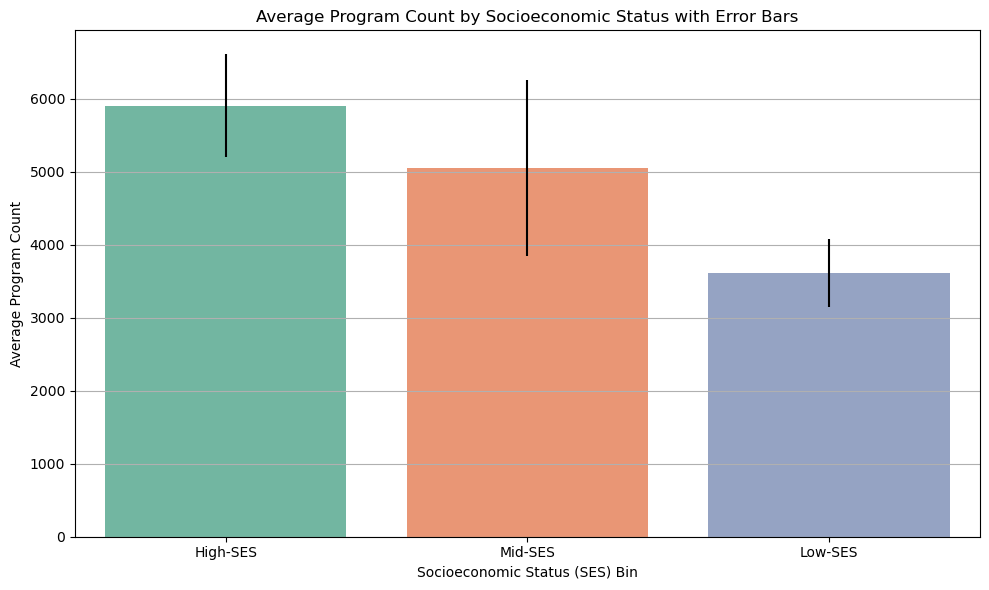

In [7]:
#| echo: false
# Plotting the average program count by SES Bin with optional error bars
plt.figure(figsize=(10, 6))
sns.barplot(
    data=average_program_count_ses,
    x='ses_bin',
    y='Hardship Program Count',
    order=['High-SES', 'Mid-SES', 'Low-SES'],
    palette='Set2',
    yerr=average_program_count_ses['sem']  # Adding custom error bars representing SEM
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Average Program Count')
plt.title('Average Program Count by Socioeconomic Status with Error Bars')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

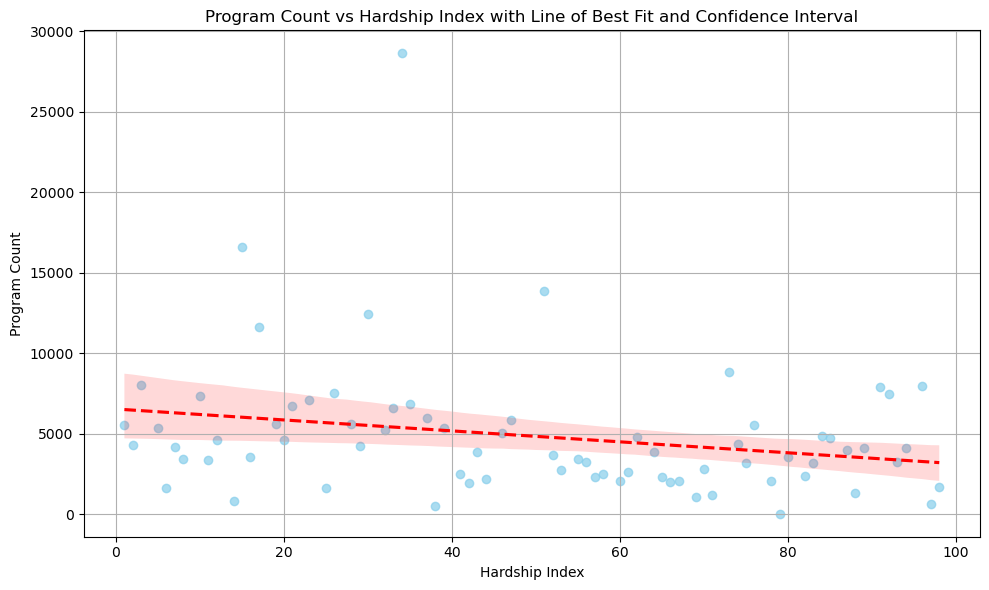

In [8]:
# Plotting Hardship Index vs Program Count with a line of best fit including confidence interval
plt.figure(figsize=(10, 6))
sns.regplot(
    data=density_income_df,
    x='HARDSHIP INDEX',
    y='Hardship Program Count',
    ci=95,  # Confidence interval level, default is 95%
    scatter_kws={'color': 'skyblue', 'alpha': 0.7},
    line_kws={'color': 'red', 'linestyle': '--'}
)

plt.xlabel('Hardship Index')
plt.ylabel('Program Count')
plt.title('Program Count vs Hardship Index with Line of Best Fit and Confidence Interval')
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


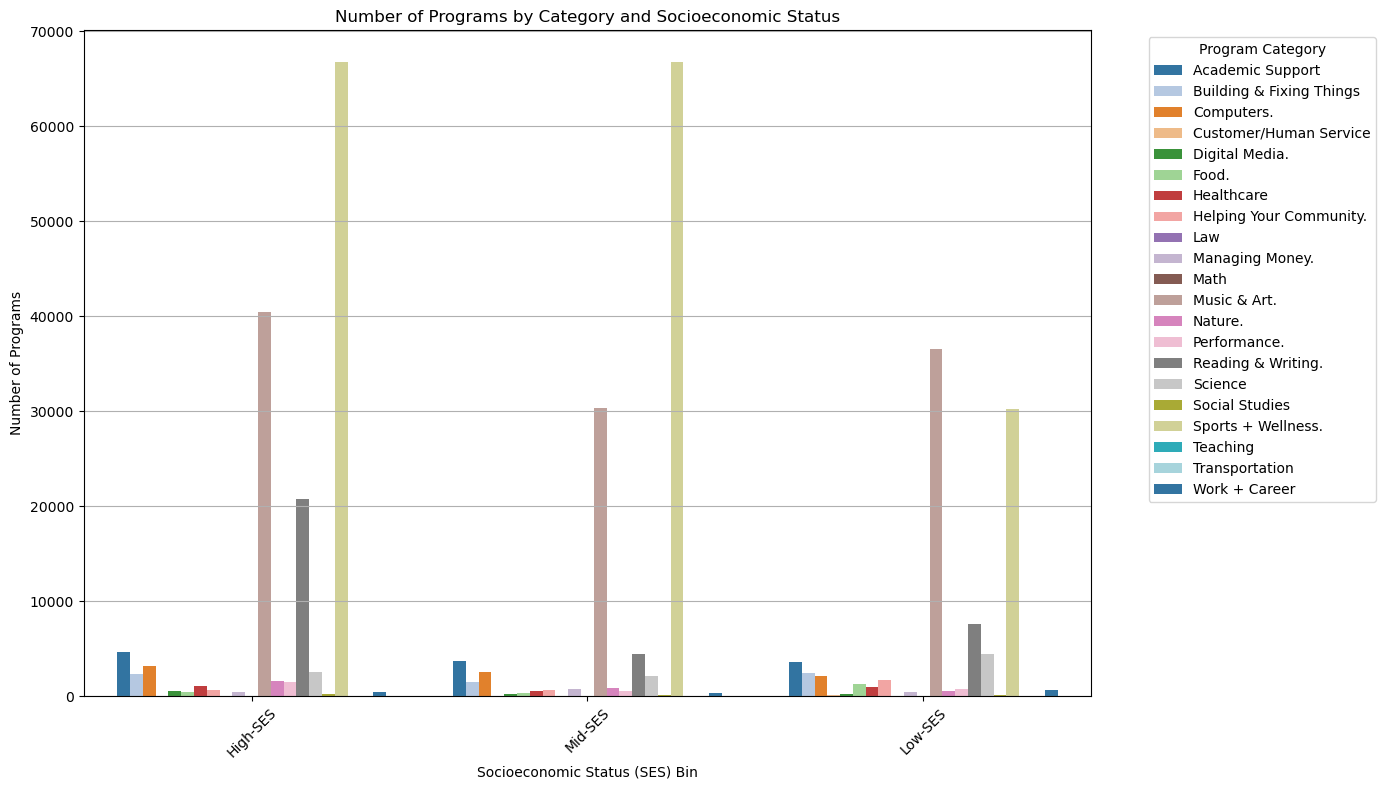

In [10]:

plt.figure(figsize=(14, 8))
sns.barplot(
    data=category_ses_counts,
    x='ses_bin',
    y='Program Count',
    hue='Category Name',
    palette=sns.color_palette('tab20', n_colors=len(category_ses_counts['Category Name'].unique()))
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs')
plt.title('Number of Programs by Category and Socioeconomic Status')
plt.xticks(rotation=45)
plt.legend(title='Program Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


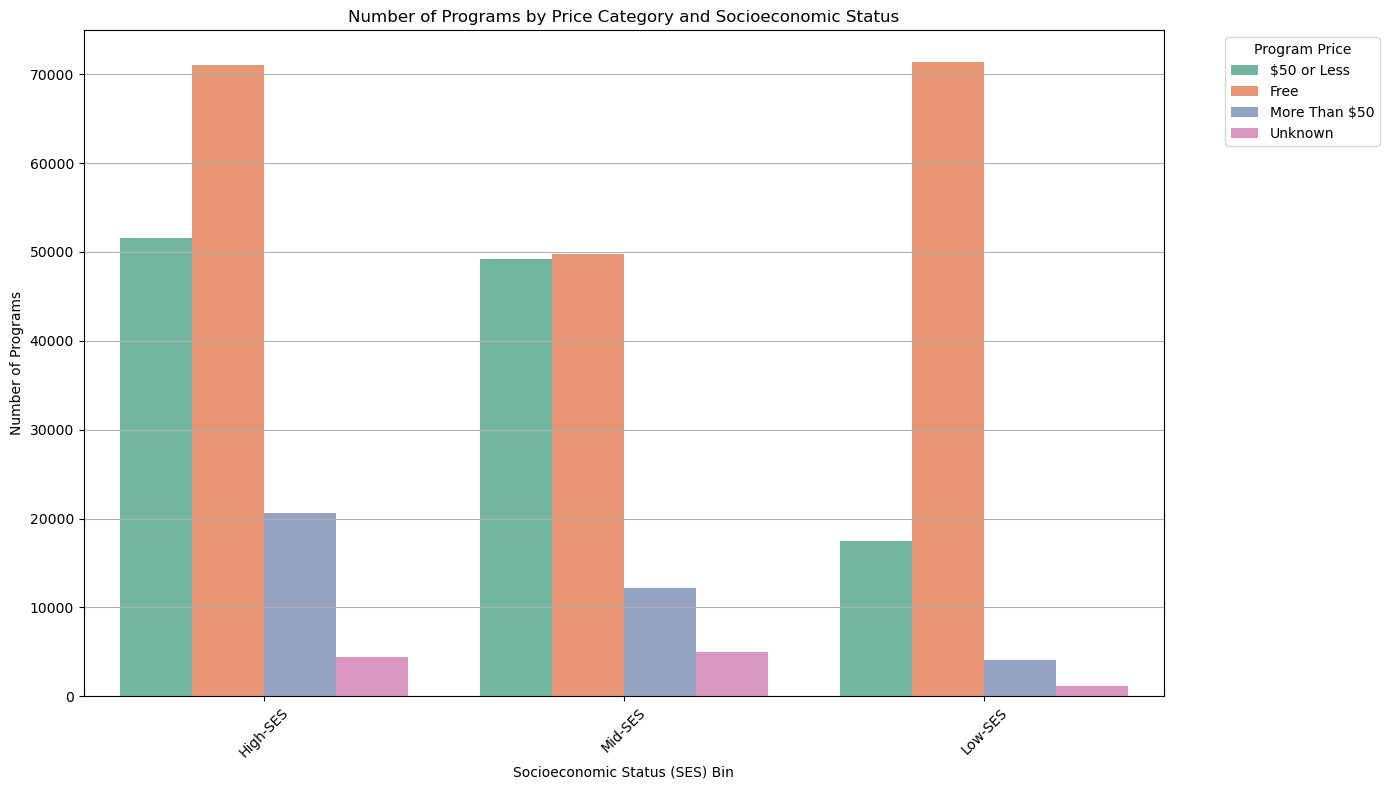

In [11]:

# Plotting the number of programs by price category and SES level
plt.figure(figsize=(14, 8))
sns.barplot(
    data=price_ses_counts,
    x='ses_bin',
    y='Count',
    hue='Program Price',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs')
plt.title('Number of Programs by Price Category and Socioeconomic Status')
plt.xticks(rotation=45)
plt.legend(title='Program Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [12]:
max_programs = program_density.loc[program_density['Hardship Program Count'].idxmax()]
print("Neighborhood with the highest number of programs:")
print(max_programs)

Neighborhood with the highest number of programs:
Geographic Cluster Name    IRVING PARK
Hardship Program Count           28641
Name: 34, dtype: object


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


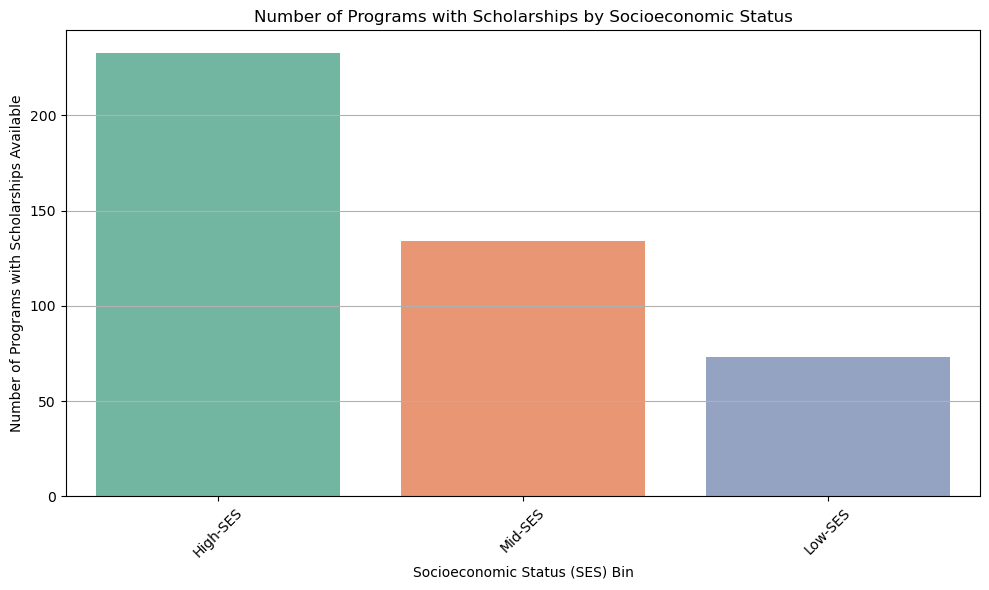

In [13]:

# Plotting the number of programs with scholarships available by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=scholarship_ses_counts,
    x='ses_bin',
    y='Scholarship Program Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Scholarships Available')
plt.title('Number of Programs with Scholarships by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


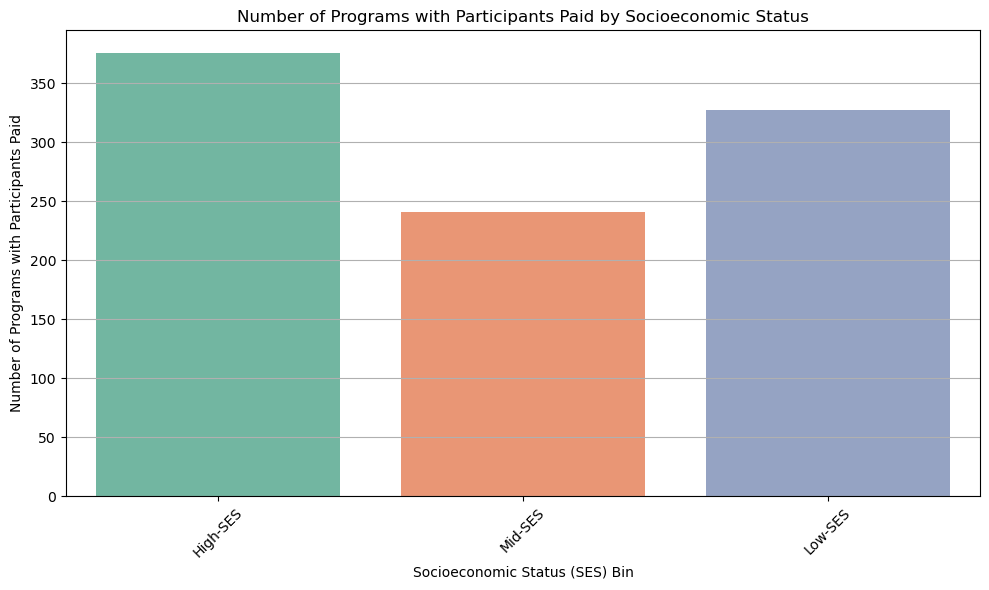

In [14]:


# Plotting the number of programs with participants paid by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=participants_paid_ses_counts,
    x='ses_bin',
    y='Participants Paid Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Participants Paid')
plt.title('Number of Programs with Participants Paid by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


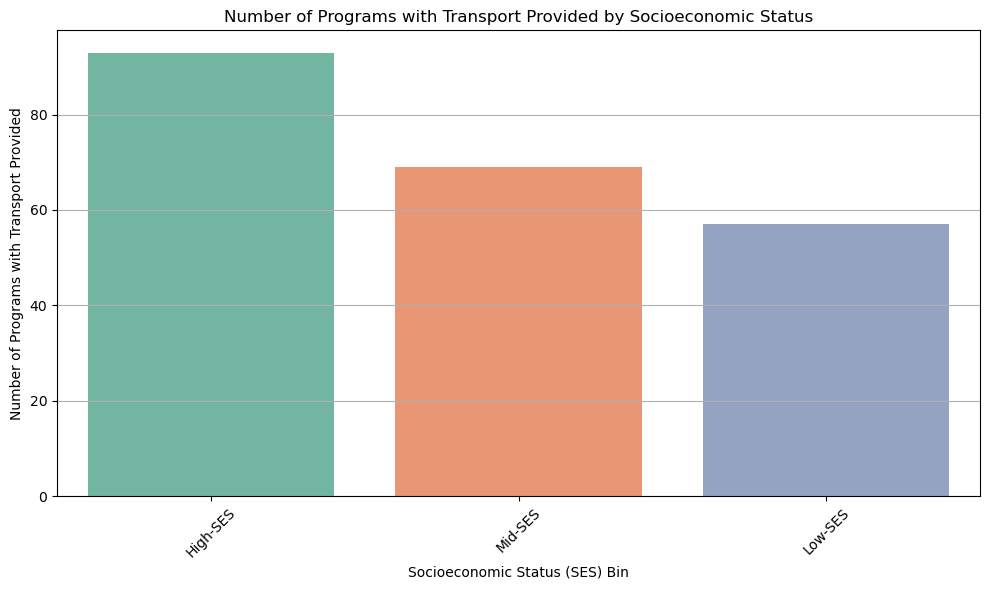

In [15]:

# Plotting the number of programs with transport provided by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=transport_ses_counts,
    x='ses_bin',
    y='Transport Provided Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Transport Provided')
plt.title('Number of Programs with Transport Provided by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


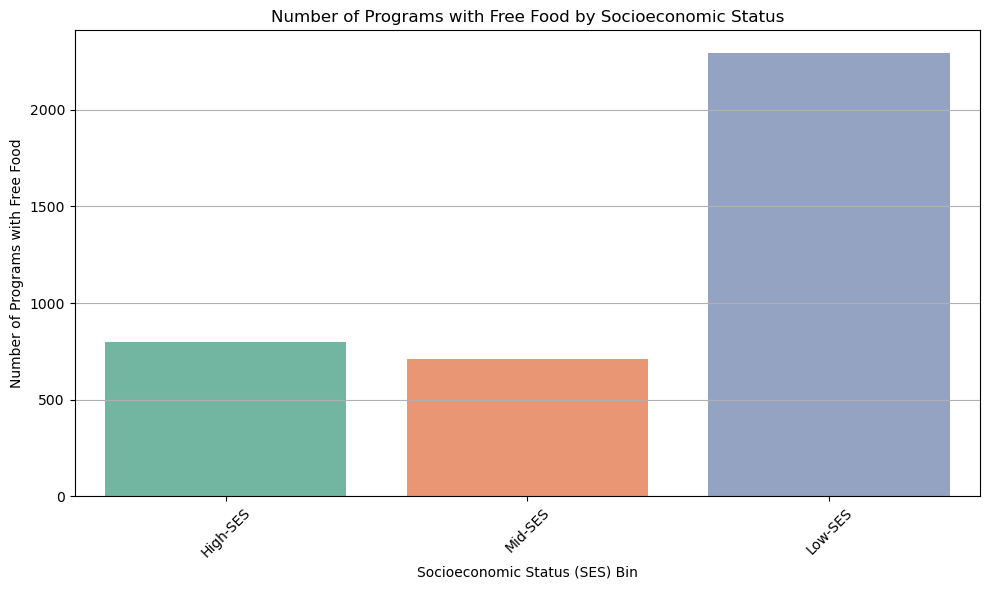

In [16]:


#Plotting the number of programs with free food by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=free_food_ses_counts,
    x='ses_bin',
    y='Free Food Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Free Food')
plt.title('Number of Programs with Free Food by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By \<Name of person doing the analysis>*

## Other sections

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.